In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, DistributedSampler, TensorDataset
import numpy as np
import io
import imageio
import matplotlib.pyplot as plt
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets.utils import download_url
import random
import os
import wandb
import tqdm
from torch.cuda.amp import autocast, GradScaler
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F


In [12]:
from torch.utils.tensorboard import SummaryWriter

In [13]:
writer = SummaryWriter('runs/conv_ae_mnist_experiment')

In [14]:
# Function to download the dataset
def download_mnist(root="."):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    val_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)
    return train_dataset, val_dataset

In [15]:
# Downloading the MNIST dataset
train_dataset, val_dataset = download_mnist()

In [16]:
# Creating DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [17]:
# Inspect the dataset
print("Training Dataset Shape: ", len(train_dataset))
print("Validation Dataset Shape: ", len(val_dataset))

Training Dataset Shape:  60000
Validation Dataset Shape:  10000


In [18]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
def ae_loss(x, recon_x):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss

In [19]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
# Define the model
input_shape = (1, 28, 28)  # MNIST images are 28x28 with 1 channel
latent_dim = 20
capacity = 64
epochs = 50
latent_dims = 20
model = AE().to(device)

In [22]:
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [23]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

encoder.conv1.weight tensor([[[[-0.0019,  0.0557, -0.1841, -0.1250],
          [-0.2498, -0.0508, -0.0386,  0.0014],
          [ 0.1788,  0.2331, -0.2490, -0.1958],
          [ 0.1493,  0.1083, -0.2160,  0.2344]]],


        [[[ 0.0810, -0.0476,  0.1711,  0.1775],
          [ 0.0157,  0.0905, -0.1598, -0.2313],
          [-0.1097, -0.0623,  0.2219, -0.1939],
          [-0.1981, -0.1449,  0.1815,  0.0348]]],


        [[[-0.0471,  0.0337,  0.1508, -0.2404],
          [-0.1845,  0.2348, -0.0888, -0.0913],
          [ 0.1163,  0.0121,  0.0301, -0.2038],
          [ 0.2175,  0.2016, -0.0339,  0.2195]]],


        ...,


        [[[ 0.0493, -0.1942, -0.0458,  0.2365],
          [ 0.0398, -0.2029, -0.0896, -0.0188],
          [-0.0488,  0.1526,  0.1699, -0.0745],
          [ 0.1186,  0.0100, -0.1865, -0.1446]]],


        [[[ 0.1921, -0.0773,  0.0761, -0.1750],
          [-0.0562, -0.1605, -0.1688,  0.0312],
          [-0.0396, -0.1768,  0.0022,  0.1199],
          [ 0.1567,  0.0991,  0.1928

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/50:   0%|          | 0/469 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/50:  98%|█████████▊| 461/469 [00:05<00:00, 83.28it/s, loss=2.65e+3]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1/50: 100%|██████████| 469/469 [00:05<00:00, 84.33it/s, loss=2.65e+3]


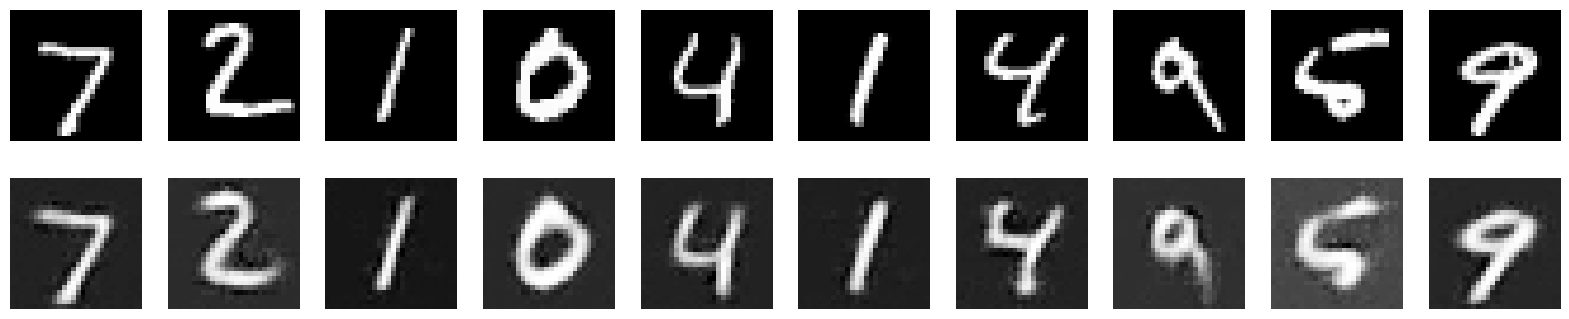

Epoch 11/50: 100%|██████████| 469/469 [00:05<00:00, 90.49it/s, loss=744]   


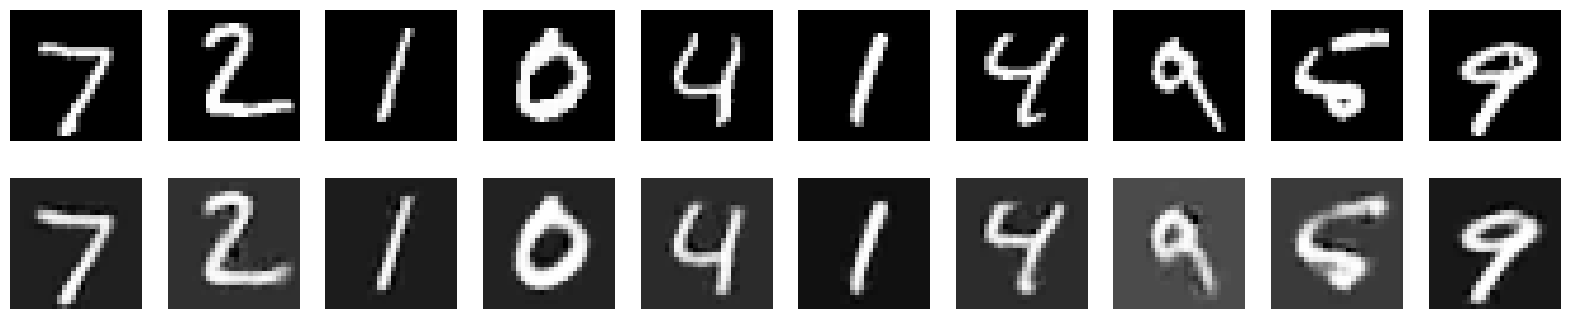

Epoch 21/50: 100%|██████████| 469/469 [00:04<00:00, 93.84it/s, loss=684]   


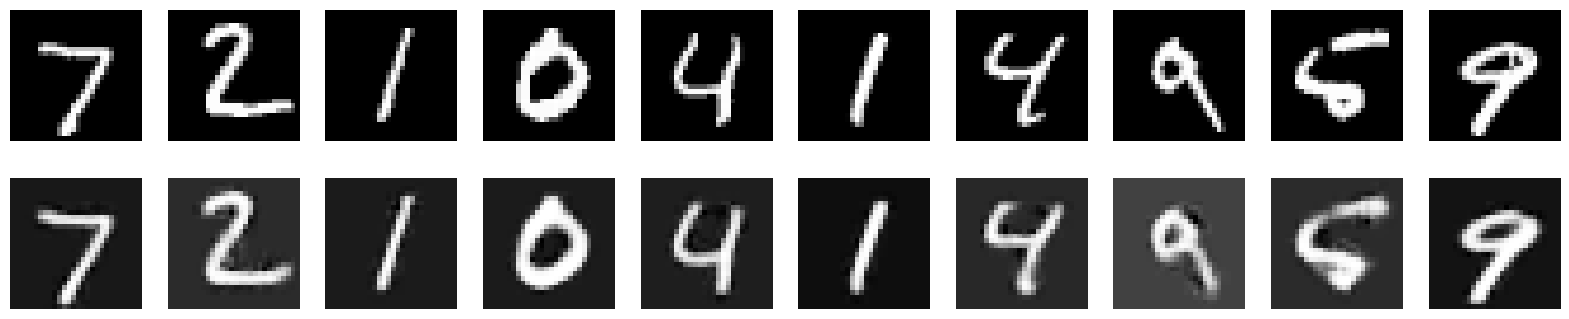

Epoch 31/50: 100%|██████████| 469/469 [00:05<00:00, 92.23it/s, loss=656]   


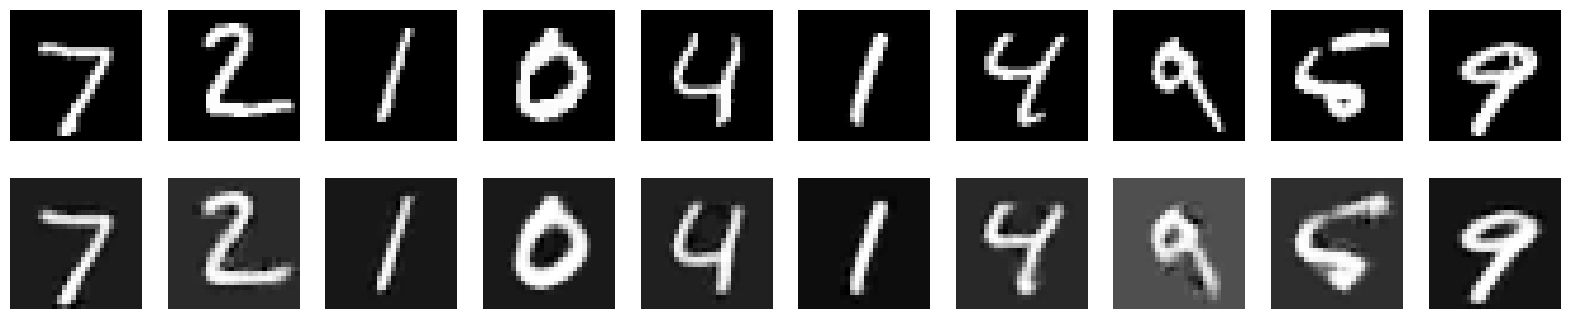

Epoch 41/50: 100%|██████████| 469/469 [00:05<00:00, 90.50it/s, loss=650]   


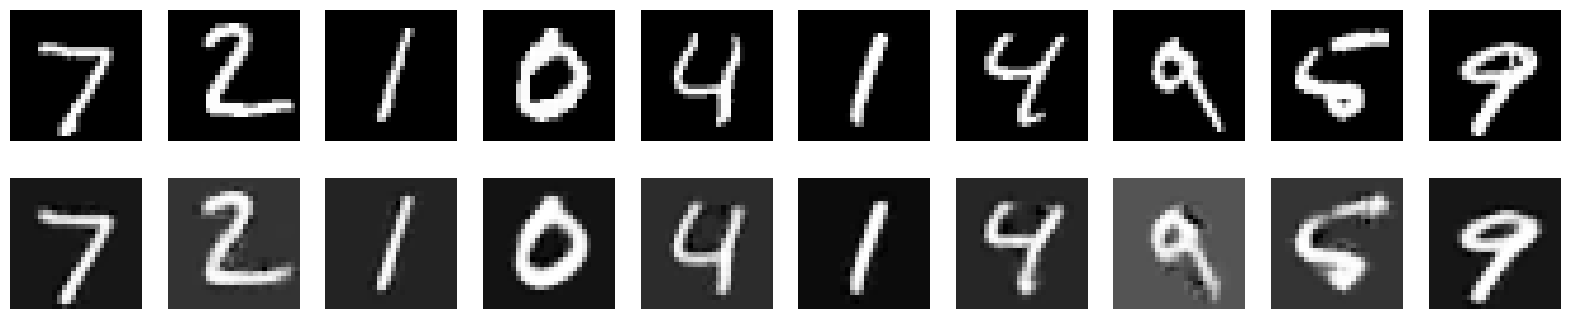

Epoch 50/50: 100%|██████████| 469/469 [00:05<00:00, 88.07it/s, loss=636]   


Loss/train,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Loss/val,█▂▁▁▁
Loss/train,626.70252
Loss/val,665.70624


In [24]:
# Train the AE model
def train(model, train_dataloader, val_dataloader, optimizer, epochs, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler()  # Initialize GradScaler
    best_loss = float('inf')
    writer = SummaryWriter()  # Initialize SummaryWriter for TensorBoard
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch, _ in pbar:
            batch = batch.to(device)  # Send the batch to the device
            optimizer.zero_grad()
            # Use autocast for mixed precision training
            with torch.cuda.amp.autocast():
                recon_x = model(batch)
                loss = ae_loss(batch, recon_x)
            # Scale the loss and call backward() to create scaled gradients
            scaler.scale(loss).backward()
            # Unscales the gradients of optimizer's assigned params in-place and call step() to update params
            scaler.step(optimizer)
            # Updates the scale for next iteration
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
        avg_loss = total_loss / len(train_dataloader)
        writer.add_scalar('Loss/train', avg_loss, epoch)  # Log the average loss for this epoch
        wandb.log({"Loss/train": avg_loss})

        # Validate and save the best model every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch, _ in val_dataloader:
                    batch = batch.to(device)  # Send the batch to the device
                    recon_x = model(batch)
                    loss = ae_loss(batch, recon_x)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_dataloader)
            writer.add_scalar('Loss/val', avg_val_loss, epoch)  # Log the average validation loss for this epoch
            wandb.log({"Loss/val": avg_val_loss})
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "mnist_ae_best.pth")
            # Visualize reconstructions
            visualize_reconstructions(model, val_dataloader, device)
            model.train()
    writer.close()

# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for examples, _ in dataloader:
            examples = examples.to(device)  # Send the batch to the device
            recon_examples = model(examples)
            break

    examples = examples.cpu().numpy()
    recon_examples = recon_examples.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(examples[i, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_examples[i, 0], cmap='gray')
        axes[1, i].axis('off')
    plt.show()


# Initialize Weights & Biases
wandb.init(project="conv_lstm_moving_mnist", name="conv_ae_regeneration_mnist")
train(model, train_loader, val_loader, optimizer, epochs, device)
wandb.finish()

In [ ]:
# from torch.cuda.amp import autocast, GradScaler
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm


# # Define the loss function for AE
# def ae_loss(x, recon_x):
#     recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
#     return recon_loss

# # Train the AE model
# def train(model, train_dataloader, val_dataloader, optimizer, epochs, device):
#     model.train()
#     scaler = GradScaler()  # Initialize GradScaler
#     best_loss = float('inf')
#     for epoch in range(epochs):
#         total_loss = 0
#         pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
#         for batch in pbar:
#             batch = batch[0].to(device)
#             optimizer.zero_grad()
#             # Use autocast for mixed precision training
#             with autocast():
#                 recon_x = model(batch)
#                 loss = ae_loss(batch, recon_x)
#             # Scale the loss and call backward() to create scaled gradients
#             scaler.scale(loss).backward()
#             # Unscales the gradients of optimizer's assigned params in-place and call step() to update params
#             scaler.step(optimizer)
#             # Updates the scale for next iteration
#             scaler.update()
#             total_loss += loss.item()
#             pbar.set_postfix({'loss': total_loss / (pbar.n + 1)})
#         avg_loss = total_loss / len(train_dataloader)
#         writer.add_scalar('Loss/train', avg_loss, epoch)  # Log the average loss for this epoch

#         # Validate and save the best model every 10 epochs
#         if epoch % 10 == 0:
#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for batch in val_dataloader:
#                     batch = batch[0].to(device)
#                     recon_x = model(batch)
#                     loss = ae_loss(batch, recon_x)
#                     val_loss += loss.item()
#             avg_val_loss = val_loss / len(val_dataloader)
#             writer.add_scalar('Loss/val', avg_val_loss, epoch)  # Log the average validation loss for this epoch
#             if avg_val_loss < best_loss:
#                 best_loss = avg_val_loss
#                 torch.save(model.state_dict(), "movingmnist_ae_best.pth")
#             #visualize reconstructions
#             visualize_reconstructions(model, val_dataloader, device)
#             model.train()
            
            
# # Function to visualize reconstructions
# def visualize_reconstructions(model, dataloader, device):
#     model.eval()
#     with torch.no_grad():
#         for examples in dataloader:
#             examples = examples[0].to(device)
#             recon_examples = model(examples)
#             break

#     examples = examples.cpu().numpy()
#     recon_examples = recon_examples.cpu().numpy()

#     fig, axes = plt.subplots(2, 10, figsize=(20, 4))
#     for i in range(10):
#         axes[0, i].imshow(examples[i, 0], cmap='gray')
#         axes[0, i].axis('off')
#         axes[1, i].imshow(recon_examples[i, 0], cmap='gray')
#         axes[1, i].axis('off')
#     plt.show()
    
# # Set up device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Define the model
# input_shape = x_train.shape[1:]
# latent_dim = 10
# model = AE(input_shape, latent_dim).to(device)

# # Define the optimizer
# #optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)

# # Train the model
# epochs = 1000
# train(model, train_loader, val_loader, optimizer, epochs, device)
# writer.close()

In [ ]:
# Visualize some example reconstructions
model.eval()
with torch.no_grad():
    examples = next(iter(val_loader))[0].to(device)
    _, _, _, recon_examples = model(examples)  # VAE returns mean, logvar, z and recon_x

num_examples = examples.shape[0]  # Get the number of examples in the batch

fig, axes = plt.subplots(2, num_examples, figsize=(20, 4))
for i in range(num_examples):
    axes[0, i].imshow(examples[i, 0].cpu().numpy(), cmap="gray")
    axes[0, i].axis("off")
    axes[1, i].imshow(recon_examples[i, 0].cpu().numpy(), cmap="gray")
    axes[1, i].axis("off")
plt.show()